In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# RBF (Radial Basis Functions) pentru regresie

## 1. Introducere

Vom folosi o reţea RBF cu K centri pentru a realiza o regresie. Intrările regresie (stratului ascuns) vor fi un set de K feature-uri 'fabricate' de cele K funcţii radiale. Pe baza acestora vom construi regresia liniară, care este o combinaţie liniară de aceste intrări radiale. Coeficienţii regresiei liniare se învaţă cu ajutorul algoritmului backpropagation.

Funcţia de activare radială $k$ pentru o intrare $x^{(i)}$, un centroid $c_k$ respectiv o 'lăţime' $\sigma_k$ a gaussienei ce o caracterizează este:

$\varphi_k(x^{(i)}) = exp\left( - \frac{\|x^{(i)}-c_k\|^2}{2\sigma_k^2} \right)$

Funcţia de loss pentru un set de date întreg $x^{(i)}, y^{(i)}$, pentru $i = 1 \dots N$, este:

$J(x, y) = \frac{1}{2}\sum_{i=1}^N \left[ y^{(i)} - f(x^{(i)}) \right]^2$, pentru care:

$f(x^{(i)}) = \sum_{k=1}^K w_k \varphi_k(x^{(i)}) + b$

Vom calcula însă eroarea de propagare înapoi pentru fiecare $x^{(i)}$ în parte, aşa încât funcţia de loss la fiecare pas este:

$J(x^{(i)}, y^{(i)}) = \frac{1}{2} \left[ y^{(i)} - f(x^{(i)}) \right]^2$

Putem astfel construi:

$\frac{\partial J_i}{\partial w_k} = \frac{\partial J}{\partial f_i} \cdot \frac{\partial f_i}{\partial w_k} = - \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, respectiv:

$\frac{\partial J_i}{\partial b} = - \left[ y^{(i)} - f(x^{(i)}) \right]$


Regulile de update devin astfel:

$w_k \leftarrow w_k + \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, şi:

$b \leftarrow b + \left[ y^{(i)} - f(x^{(i)}) \right])$


## 2. Setul de date

Sunt alese aleator 100 de puncte între $[0, 1)$, şi construim o 'sinusoidă' perturbată pentru punctele astfel alese:

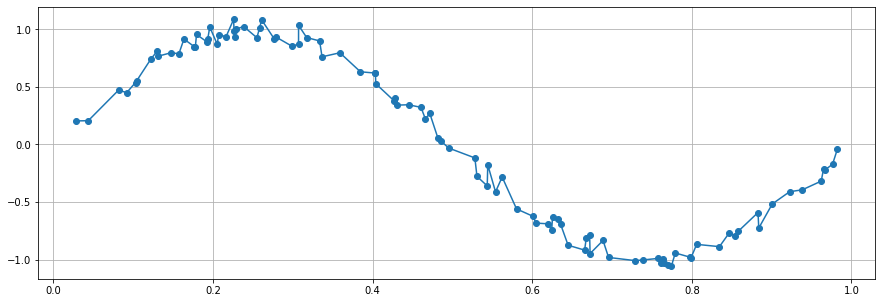

In [2]:
samples = 100
x = np.random.uniform(low=0.0, high=1.0, size=samples)
x = np.sort(x, axis=0)

noise = np.random.uniform(low=-0.1, high=0.1, size=samples)
y = np.sin(2 * np.pi * x)  + noise
 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

## 3. Algoritmul K-means

K-means este folosit pentru construcţia centroizilor. Acolo vom 'centra' cele K gaussiene.

1. se aleg cei K centri aleator dintre cele 100 de puncte existente
2. calculează distanţa de la fiecare punct la fiecare dintre cei K centroizi
3. pentru fiecare punct, se găseşte cel mai apropiat centroid de punctul respectiv
4. pentru fiecare din cei K centroizi, se recalculează media cluster-ului ca fiind media punctelor celor mai apropiate de acel centroid
5. centroidul devine media astfel calculată
6. repetă paşii 2 - 5 până când centroizii au o deplasare sub $10^{-6}$

Algoritmul K-means va întoarce centroizii împreună cu deviaţia standard a fiecărui cluster, asociat acelui centroid.

Dacă există clustere cu mai puţin de doi reprezentanţi, deviaţia standard ($\sigma$) a acelui cluster va fi calculată ca media deviaţiilor standard ale clusterelor care nu se află în această situaţie.

In [3]:
def kmeans(x, k):
    # choose k centers at random, from existing samples
    centers = np.random.choice(x, k, replace=False)
    
    converged = False
    while not converged:
        # compute distance from every point to all centers
        distance = np.abs(x - centers.reshape(-1, 1))
        point_cluster = np.argmin(distance, axis=0)
        
        # recompute the centers by computing the mean of every cluster
        means = np.zeros_like(centers)
        np.add.at(means, point_cluster, x)
        count = np.zeros_like(centers)
        np.add.at(count, point_cluster, 1)

        count_zero = count > 0
        new_centers = np.zeros_like(centers)
        new_centers[count_zero] = means[count_zero] / count[count_zero]
        
        if np.all(np.abs(centers - new_centers) < 1e-4):
            converged = True
            clusters = [x[point_cluster == i] for i in range(k)]

        centers = new_centers
        
            
    # compute the standard deviations of clusters
    stds = np.array([np.std(clusters[index]) for index in range(k)])
    
    # find clusters with less than 2 points and make std = 0
    indexes = np.array([index for index in range(k) if clusters[index].shape[0] < 2])
        
    # set that cluster std as the mean of the rest of stds
    if(indexes.shape[0] > 0):
        stds[indexes] = stds.sum() / (k - indexes.shape[0])
    
    return centers, stds

In [4]:
k = 50
centers, stds = kmeans(x, k)

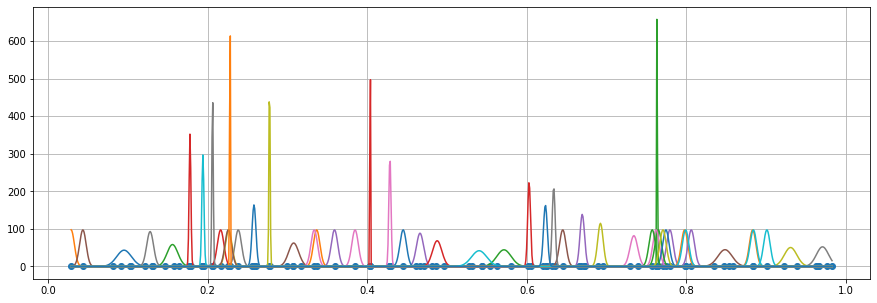

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, np.zeros_like(x), '-o')
v = np.linspace(x.min(), x.max(), 1000)
for i in range(k):
    ax.plot(v, stats.norm.pdf(v, loc=centers[i], scale=stds[i]))
ax.grid() ; plt.show() 

Observaţi cum apar mai multe gaussiene în zonele cu puncte mai dese. Încercaţi să modificaţi numărul de clustere.

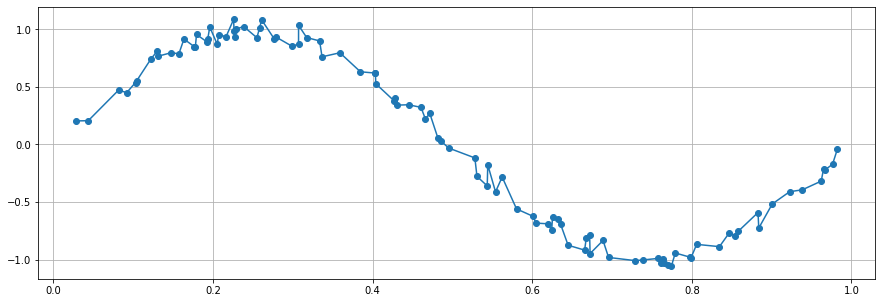

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

In [7]:
def rbf(x, c, sigma):
    return np.exp(- (x - c) ** 2 / (2 * sigma ** 2))

## 4. Instruirea ponderilor stratului ascuns

Realizaţi, în fiecare epocă, parcurgerea sample cu sample. Pentru fiecare sample $x^{(i)}$ astfel ales, calculaţi valoarea activării (funcţia $f(\cdot)$), loss-ului şi a lui delta.

In [8]:
lr = 0.05
epochs = 200
w = np.random.randn(k)
b = np.random.randn(1)

for epoch in range(epochs):
    for i in range(len(x)):
        a = rbf(x[i], centers, stds)
        f = (w * a).sum() + b
        loss = (y[i] - f) ** 2
        delta = -(y[i] - f)
        
        w += -delta * a * lr
        b += -delta * lr

Definiţi funcţia de inferenţă, de calcul a activării pentru fiecare element, $y\_pred^{(i)} = f(x^{(i)})$.

In [9]:
def inference(x):
    a = np.array([rbf(x[i], centers, stds) for i in range(len(x))])
    y_pred = (w * a).sum(axis=1) + b
    return np.array(y_pred)

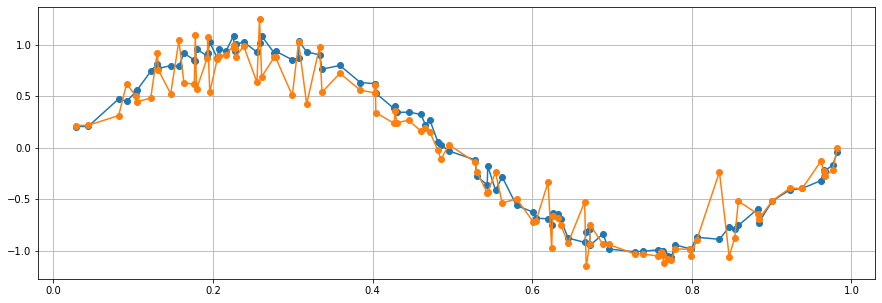

In [10]:
y_pred = inference(x)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.plot(x, y_pred, '-o')
ax.grid() ; plt.show() 

## 5. Fine-tuning

Realizaţi:
* regularizarea ponderilor stratului ascuns
* modificaţi numărul de clustere K şi găsiţi cea mai bună valoare
* găsiţi cel mai bun parametru de regularizare şi cea mai bună rată de învăţare

In [11]:
def train(k, lmbda, lr, centers, stds):
    epochs = 200
    w = np.random.randn(k)
    b = np.random.randn(1)

    for epoch in range(epochs):
        loss = 0
        for i in range(len(x)):
            a = rbf(x[i], centers, stds)
            f = (w * a).sum() + b
            loss += ((y[i] - f) ** 2 + (lmbda / 2) * np.sum(w ** 2))
            delta = -(y[i] - f)
            
            w -= delta * a * lr + w * lmbda
            b -= delta * lr
    
    return w, b, loss[0]

In [12]:
lmbda = 0
k = [1, 2, 4, 8, 12, 16, 20, 28]
lr = 0.05

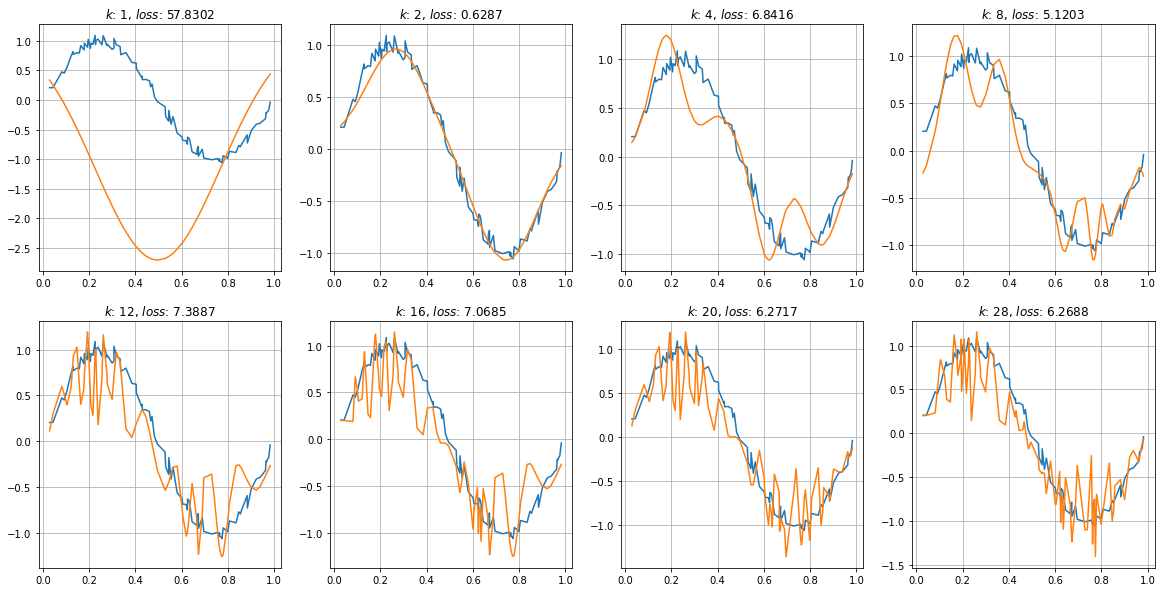

In [13]:
y_pred = []
loss = []
for c in k:
    centers, stds = kmeans(x, c)
    w, b, l = train(c, lmbda, lr, centers, stds)
    y_pred.append(inference(x))
    loss.append(l)
    
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(len(y_pred)):
    ax[i//4, i % 4].set_title(f'$k$: {k[i]}, $loss$: {round(loss[i], 4)}')
    ax[i//4, i % 4].plot(x, y, '-')
    ax[i//4, i % 4].plot(x, y_pred[i], '-')
    ax[i//4, i % 4].grid()

plt.show()

In [32]:
lmbda = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9, 1e-12, 0]
k = 2
lr = 0.05

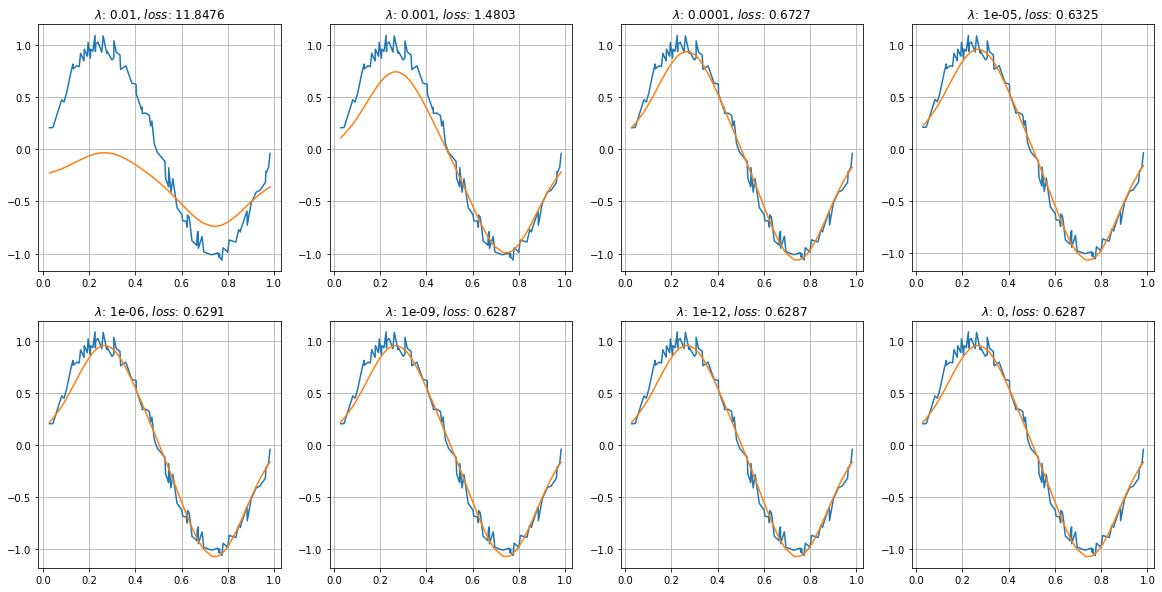

In [33]:
y_pred = []
loss = []
centers, stds = kmeans(x, k)

for l in lmbda:
    w, b, c = train(k, l, lr, centers, stds)
    y_pred.append(inference(x))
    loss.append(c)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(len(y_pred)):
    ax[i//4, i % 4].set_title(f'$\lambda$: {lmbda[i]}, $loss$: {round(loss[i], 4)}')
    ax[i//4, i % 4].plot(x, y, '-')
    ax[i//4, i % 4].plot(x, y_pred[i], '-')
    ax[i//4, i % 4].grid()

plt.show()

In [36]:
lmbda = 1e-6
k = 2
lr = [0.5, 0.1, 0.05, 0.03, 0.01, 0.008, 0.004, 0.001]

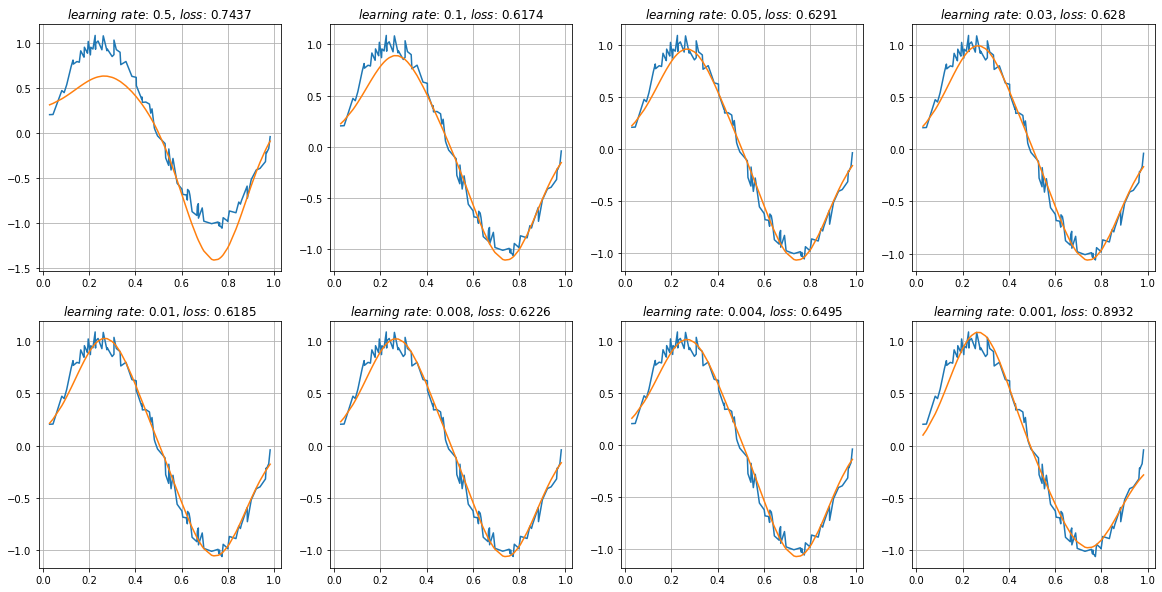

In [39]:
y_pred = []
loss = []
centers, stds = kmeans(x, k)

for l in lr:
    w, b, c = train(k, lmbda, l, centers, stds)
    y_pred.append(inference(x))
    loss.append(c)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(len(y_pred)):
    ax[i//4, i % 4].set_title(f'$learning\ rate$: {lr[i]}, $loss$: {round(loss[i], 4)}')
    ax[i//4, i % 4].plot(x, y, '-')
    ax[i//4, i % 4].plot(x, y_pred[i], '-')
    ax[i//4, i % 4].grid()

plt.show()

Am ales $/k = 2$ pentru care modelul realizeaza o aproximare buna a datelor. Deoarece complexitatea modelului este redusa, nu este necesar un factor de regularizare mare, alegand $\lambda = 1e-6$. Am ales rata de invatare $0.1$, avend cea mai mica pierdere pe modelul meu.

In [40]:
lmbda = 1e-6
k = 2
lr = 0.05

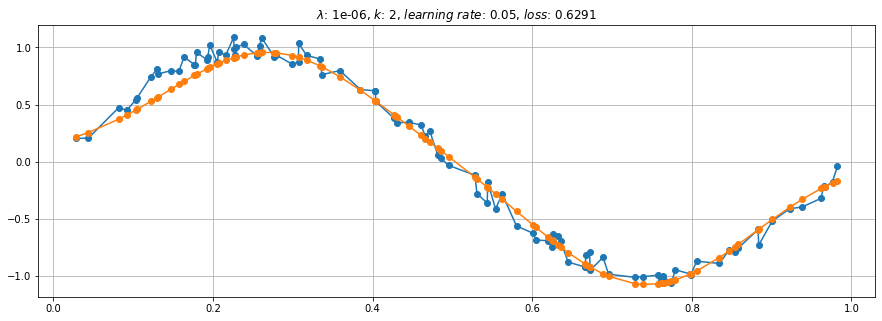

In [41]:
centers, stds = kmeans(x, k)
w, b, loss = train(k, lmbda, lr, centers, stds)

y_pred = inference(x)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.plot(x, y_pred, '-o')
ax.set_title(f'$\lambda$: {lmbda}, $k$: {k}, $learning\ rate$: {lr}, $loss$: {round(loss, 4)}')
ax.grid() ; plt.show() 